<a href="https://colab.research.google.com/github/MurtazAlek/MLDM-2021/blob/main/Murtazina_%22MLDM_2021_seminar11_homework_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please, fill in before you start: First Name: **Aleksandra**

Last Name: **Murtazina**

Group:

For WGAN did NOT use the loss metric the same as in GAN (sigmoid_cross_entropy_with_logits)

d_loss = fake_loss - real_loss

g_loss = -tf.reduce_mean(fake_img)

computation for only 5 epochs, as the GPU does not work correctly
but faces after 5 WGAN epochs are not much worse than after 20 GAN epochs


<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2021/blob/master/11-gans/MLDM_2021_seminar11_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement a GAN with convolutional architecture (2 points)

Build your own CNN architecture to improve the quality of generated images for the same dataset we used during the practical session.

You may reuse the code given below, or you may change/improve it as well.

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
from tqdm import tqdm
from tqdm import trange

from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import clear_output

2.7.0


In [2]:
lfw = tfds.image_classification.LFW()
lfw.download_and_prepare()
ds = lfw.as_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteI307QW/lfw-train.tfrecord


  0%|          | 0/13233 [00:00<?, ? examples/s]

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
def get_img(x):
  return x['image'][80:-80,80:-80]

data = np.array([
  np.array(Image.fromarray(img.numpy()).resize((36, 36)))
  for img in tqdm(ds['train'].map(get_img))
])

100%|██████████| 13233/13233 [00:13<00:00, 969.39it/s] 


In [4]:
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)
print(X_train.shape)

0.0 1.0 float32
(13233, 36, 36, 3)


In [5]:
LATENT_DIM = 32

generator = tf.keras.Sequential(
    [
        keras.Input(shape=(LATENT_DIM,)),
        layers.Dense(9 * 9 * 128),
        layers.Reshape((9, 9, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=4, padding="same"),
],
name='generator',
)

discriminator = keras.Sequential(
    [
        keras.Input(shape=( 36, 36, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1),
    ],
    name="discriminator",
)

In [ ]:
def gen_images(num):
  return generator(tf.random.normal(shape=(num, LATENT_DIM)))


@tf.function
def forward(batch):
  real = batch
  fake = gen_images(len(batch))

  shape = (len(batch), 1)
  labels_real = tf.ones (shape=shape)
  labels_fake = tf.zeros(shape=shape)

  X = tf.concat([real, fake], axis=0)
  y = tf.concat([labels_real, labels_fake], axis=0)

  loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(y, discriminator(X, training=True))
  )
  return loss

opt_d = tf.optimizers.RMSprop()
opt_g = tf.optimizers.RMSprop()

@tf.function
def disc_step(batch):
  with tf.GradientTape() as t:
    d_loss = forward(batch)
  grads = t.gradient(d_loss, discriminator.trainable_variables)
  opt_d.apply_gradients(zip(grads, discriminator.trainable_variables))
  return d_loss

@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = -forward(batch)
  grads = t.gradient(g_loss, generator.trainable_variables)
  opt_g.apply_gradients(zip(grads, generator.trainable_variables))
  return g_loss

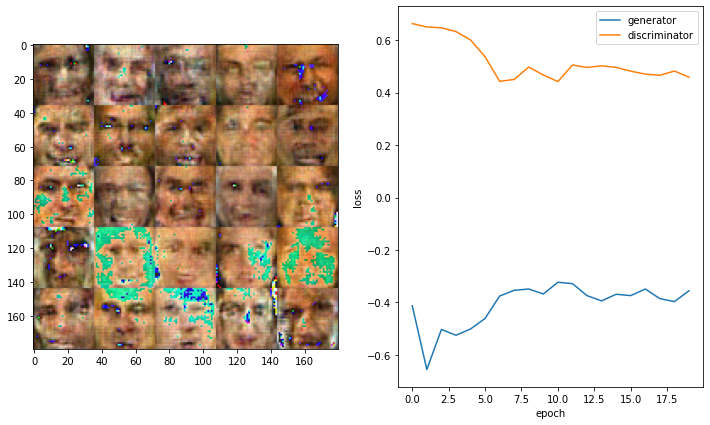

Done with epoch # 19


In [ ]:
BATCH_SIZE = 128

N_EPOCHS = 20
NUM_DISC_STEPS = 5

i_disc_step = 0
losses_gen = []
losses_disc = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss_gen = []
  epoch_loss_disc = []
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]

    if i_disc_step < NUM_DISC_STEPS:
      # discriminator update
      i_disc_step += 1
      epoch_loss_disc.append(disc_step(batch).numpy())
    else:
      # generator update
      i_disc_step = 0
      epoch_loss_gen.append(gen_step(batch).numpy())

  losses_gen.append(np.mean(epoch_loss_gen))
  losses_disc.append(np.mean(epoch_loss_disc))

  opt_d.learning_rate.assign(opt_d.learning_rate * 0.99)
  opt_g.learning_rate.assign(opt_g.learning_rate * 0.99)

  imgs = (gen_images(25).numpy() * 255).astype('uint8')
  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
  plt.subplot(1, 2, 2)
  plt.plot(losses_gen, label='generator')
  plt.plot(losses_disc, label='discriminator')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print("Done with epoch #", i_ep)

# Implement a [Wasserstein GAN](https://arxiv.org/abs/1704.00028) with gradient penalty term (4 points)

Replace previously build model with WGAN, you may reuse the code above. The dataset is the same, but you may use MNIST in case you want to perform a conditional generation.

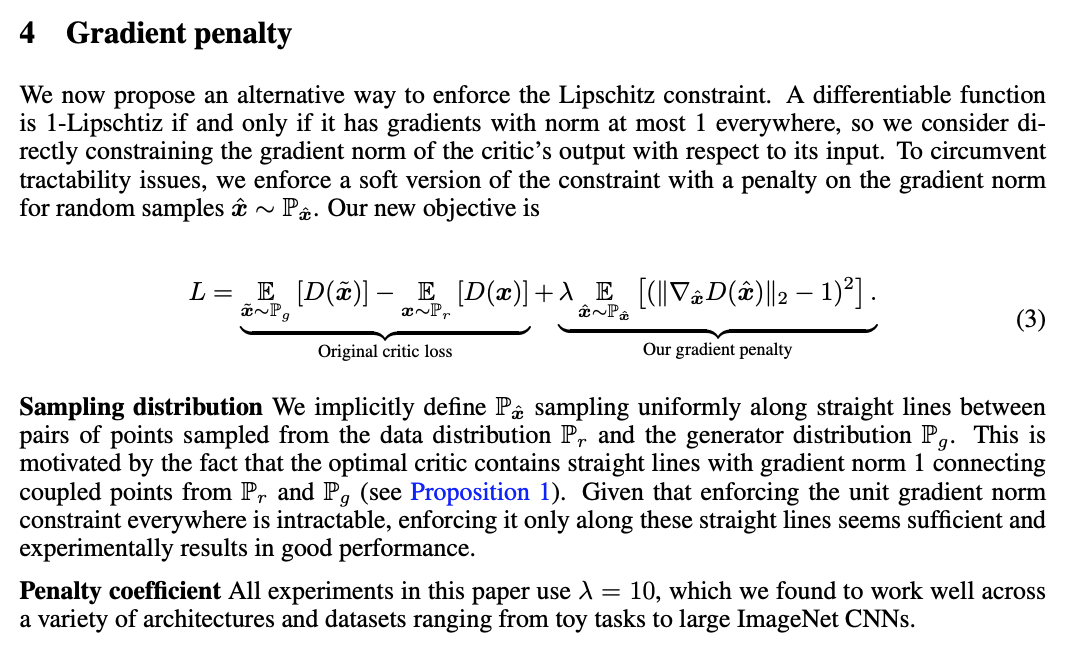

In [6]:
def gradient_penalty(batch_size, real_images, fake_images):
    alpha = tf.random.normal([batch_size, 1, 1, 3], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
      gp_tape.watch(interpolated)
      pred = discriminator(interpolated, training=True)

    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

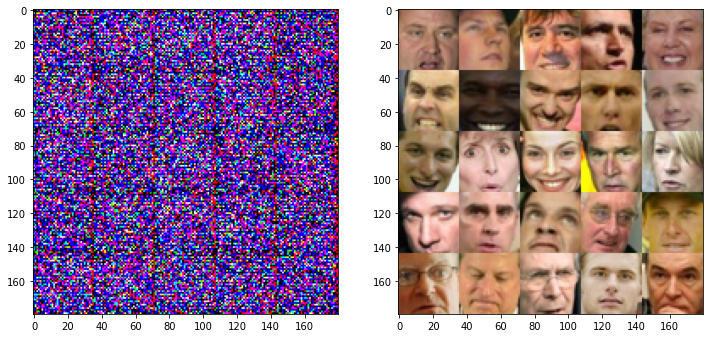

In [ ]:
random_latent_vectors = tf.random.normal(shape=(25, LATENT_DIM))
fake_images = generator(random_latent_vectors)
fake_images = (fake_images.numpy() * 255).astype('uint8')
real_images = (X_train[:25]*255).astype('uint8')
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.imshow(fake_images.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
plt.subplot(1, 2, 2)
plt.imshow(real_images.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))

In [7]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

In [8]:
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [9]:
BATCH_SIZE = 128
NUM_DISC_STEPS = 5
gp_weight=10.0
d_optimizer = tf.optimizers.RMSprop()
g_optimizer = tf.optimizers.RMSprop()

def train_step(X_train):
    epoch_loss_gen = []
    epoch_loss_disc = []
    shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
    for i_img in trange(0, len(X_train), BATCH_SIZE):
      batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]
      
      for i in range(NUM_DISC_STEPS):
        random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM))
        with tf.GradientTape() as tape:
          fake_images = generator(random_latent_vectors)
          fake_logits = discriminator(fake_images)
          real_logits = discriminator(batch)
          d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
          gp = gradient_penalty(BATCH_SIZE, batch, fake_images)
          d_loss = d_cost + gp * gp_weight
          epoch_loss_disc.append(d_loss.numpy())
            
        d_gradient = tape.gradient(d_loss, discriminator.trainable_variables)
        d_optimizer.apply_gradients(
                zip(d_gradient, discriminator.trainable_variables))

      
      random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM))
      with tf.GradientTape() as tape:
        generated_images = generator(random_latent_vectors)
        gen_img_logits = discriminator(generated_images)
        g_loss = generator_loss(gen_img_logits)
        epoch_loss_gen.append(g_loss.numpy())

      gen_gradient = tape.gradient(g_loss, generator.trainable_variables)
      g_optimizer.apply_gradients(
            zip(gen_gradient, generator.trainable_variables))
    return np.mean(epoch_loss_gen), np.mean(epoch_loss_disc)

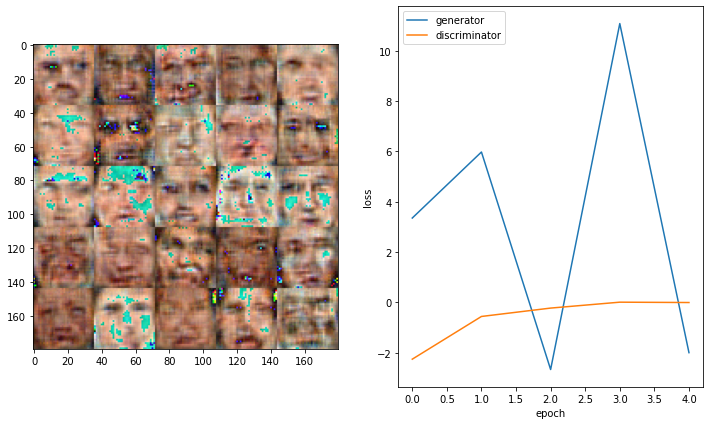

Done with epoch # 5


In [10]:
N_EPOCHS = 5

losses_gen = []
losses_disc = []
for i_ep in range(N_EPOCHS): 
  epoch_loss_gen, epoch_loss_disc = train_step(X_train[49:]) 
  losses_gen.append(epoch_loss_gen)
  losses_disc.append(epoch_loss_disc)

  random_latent_vectors = tf.random.normal(shape=(25, LATENT_DIM))
  images = generator(random_latent_vectors)
  imgs = (images.numpy() * 255).astype('uint8')
  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
  plt.subplot(1, 2, 2)
  plt.plot(losses_gen, label='generator')
  plt.plot(losses_disc, label='discriminator')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print("Done with epoch #", i_ep+1) 
# print(losses_gen)
# print(losses_disc) 